# Spatio-temporal data

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Aagam0812/DataMining/blob/main/Assignment9/Spatio-temporal.ipynb)


In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error
from scipy.stats import zscore

  # Step 1: Exploratory Data Analysis (EDA)

  # 1.1. Data Loading and Initial Exploration
  
We'll start by loading the dataset and examining the first few rows to understand its structure.

In [3]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/gdrive/MyDrive/DataMining/GTFS_Data.csv')

# Display the first few rows of the dataset
data.head()


,stop_id_from,stop_id_to,trip_id,arrival_time,time,speed,Number_of_trips,SRI,Degree_of_congestion
0,36156,38709,NORMAL_333_Pune Station To Hinjawadi Maan Pha...,09:13:54,0.027222,14.479565,9.0,-0.40816322,Very smooth
1,36156,38709,NORMAL_115P_Pune Station to Hinjawadi Phase 3_...,09:03:01,0.032222,12.232736,9.0,1.2068965,Smooth
2,36156,38709,NORMAL_100_Ma Na Pa to Hinjawadi Maan Phase 3_...,09:15:00,0.058333,6.757130,9.0,5.142857,Heavy congestion
3,36156,38709,NORMAL_VJR5_Ma Na Pa To Mukai Chowk_Up-0905_0,09:05:00,0.033611,11.727251,9.0,1.570248,Smooth
4,36156,38709,NORMAL_100_Ma Na Pa to Hinjawadi Maan Phase 3_...,09:00:00,0.058333,6.757130,9.0,5.142857,Heavy congestion


The dataset contains the following columns:

* stop_id_from: ID of the starting stop.
* stop_id_to: ID of the destination stop.
* trip_id: Identifier for the trip.
* arrival_time: The time of arrival at the destination.
* time: The duration taken for the trip (seems to be in fractions of hours).
* speed: Speed during the trip.
* Number_of_trips: The number of trips taken.
* SRI: Some index (we'll need more information on this).
* Degree_of_congestion: Categorical variable indicating the degree of traffic congestion.


  # 1.2. Data Summary and Types
Let's get a summary of the data, including data types, missing values, and basic statistics for numerical columns.​

In [4]:
# Summary of the dataset
data_info = data.info()

# Basic statistics for numerical columns
data_description = data.describe()

data_info, data_description


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66913 entries, 0 to 66912
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stop_id_from          66913 non-null  int64  
 1   stop_id_to            66913 non-null  int64  
 2   trip_id               66913 non-null  object 
 3   arrival_time          66644 non-null  object 
 4   time                  66913 non-null  float64
 5   speed                 66655 non-null  float64
 6   Number_of_trips       66912 non-null  float64
 7   SRI                   66600 non-null  object 
 8   Degree_of_congestion  66913 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 4.6+ MB


(None,
        stop_id_from    stop_id_to          time         speed  Number_of_trips
 count  66913.000000  66913.000000  66913.000000  6.665500e+04     66912.000000
 mean   33078.882683  33096.450286      0.044127           inf        16.566236
 std    11893.792935  11873.818983      0.737762           NaN        18.882254
 min      386.000000    386.000000      0.000000  0.000000e+00         1.000000
 25%    33494.000000  33496.000000      0.009444  2.168910e+01         4.000000
 50%    38784.000000  38785.000000      0.015000  3.148695e+01         9.000000
 75%    39280.000000  39284.000000      0.024444  4.145599e+01        23.000000
 max    40516.000000  40516.000000     23.998611           inf       141.000000)

Here's what we've observed from the dataset summary:

The dataset contains 66,913 entries.

Columns and their types:

* stop_id_from (int64)
* stop_id_to (int64)
* trip_id (object)
* arrival_time (object)
* time (float64)
* speed (float64)
* Number_of_trips (float64)
* SRI (object)
* Degree_of_congestion (object)

There are missing values in the arrival_time, speed, Number_of_trips, and SRI columns.

The speed column has infinite values, which is not realistic for traffic data and suggests potential data errors.

  # 1.3. Handling Missing Values
We need to address the missing values. There are several strategies to handle missing values, such as:

Removing rows with missing values.
Imputing the mean, median, or mode value for the missing entries.
Using more complex imputation techniques like k-Nearest Neighbors or regression imputation.

For the speed column, we need to handle the infinite values as well. We could replace them with NaN and then apply the above strategies or compute the speed from other columns if possible.

#### 1.3.1. Handling Infinite Values in the speed Column
First, we'll replace infinite values in the speed column with NaN (Not a Number). Then, we'll handle the NaN values.

In [5]:
import numpy as np

# Replace infinite values with NaN
data['speed'] = data['speed'].replace([np.inf, -np.inf], np.nan)

# Check the number of missing values in each column
missing_values = data.isnull().sum()

missing_values


stop_id_from              0
stop_id_to                0
trip_id                   0
arrival_time            269
time                      0
speed                   419
Number_of_trips           1
SRI                     313
Degree_of_congestion      0
dtype: int64

In [6]:
# Checking unique values in the 'speed' column to identify any anomalies
unique_speed_values = data['speed'].unique()

# Displaying the first few unique values for inspection
unique_speed_values[:10]


array([14.47956475, 12.23273572,  6.7571302 , 11.72725073,  9.71915971,
       10.58953241,  8.98099576, 24.77463621, 30.43741104, 30.00871476])

The unique values in the speed column appear to be typical speed values, and I don't immediately see any anomalies such as infinite values.

### 1.3.2. Handling Missing Values
Given the nature of the dataset (spatio-temporal traffic prediction), for the numerical columns with missing values, we'll impute using the median (as it's less sensitive to outliers). For categorical columns, we'll use the mode.

We'll address the following columns:

* arrival_time: Impute with the mode (most frequent value).
* speed: Impute with the median.
* Number_of_trips: Impute with the median.
* SRI: Impute with the mode.

In [7]:
# Imputing missing values

# For 'arrival_time' and 'SRI' columns, impute with mode
data['arrival_time'].fillna(data['arrival_time'].mode()[0], inplace=True)
data['SRI'].fillna(data['SRI'].mode()[0], inplace=True)

# For 'speed' and 'Number_of_trips' columns, impute with median
data['speed'].fillna(data['speed'].median(), inplace=True)
data['Number_of_trips'].fillna(data['Number_of_trips'].median(), inplace=True)

# Check if there are any missing values left
missing_values_after_imputation = data.isnull().sum()

missing_values_after_imputation


stop_id_from            0
stop_id_to              0
trip_id                 0
arrival_time            0
time                    0
speed                   0
Number_of_trips         0
SRI                     0
Degree_of_congestion    0
dtype: int64

  # 1.4. Visualization
To better understand the data, visualizations can be invaluable. Here are some visualizations we can generate:

* Histograms for numerical columns (time, speed, and Number_of_trips) to observe their distributions.

* A bar plot for the Degree_of_congestion column to see the distribution of congestion levels.

* A scatter plot between speed and time to observe any relationship.

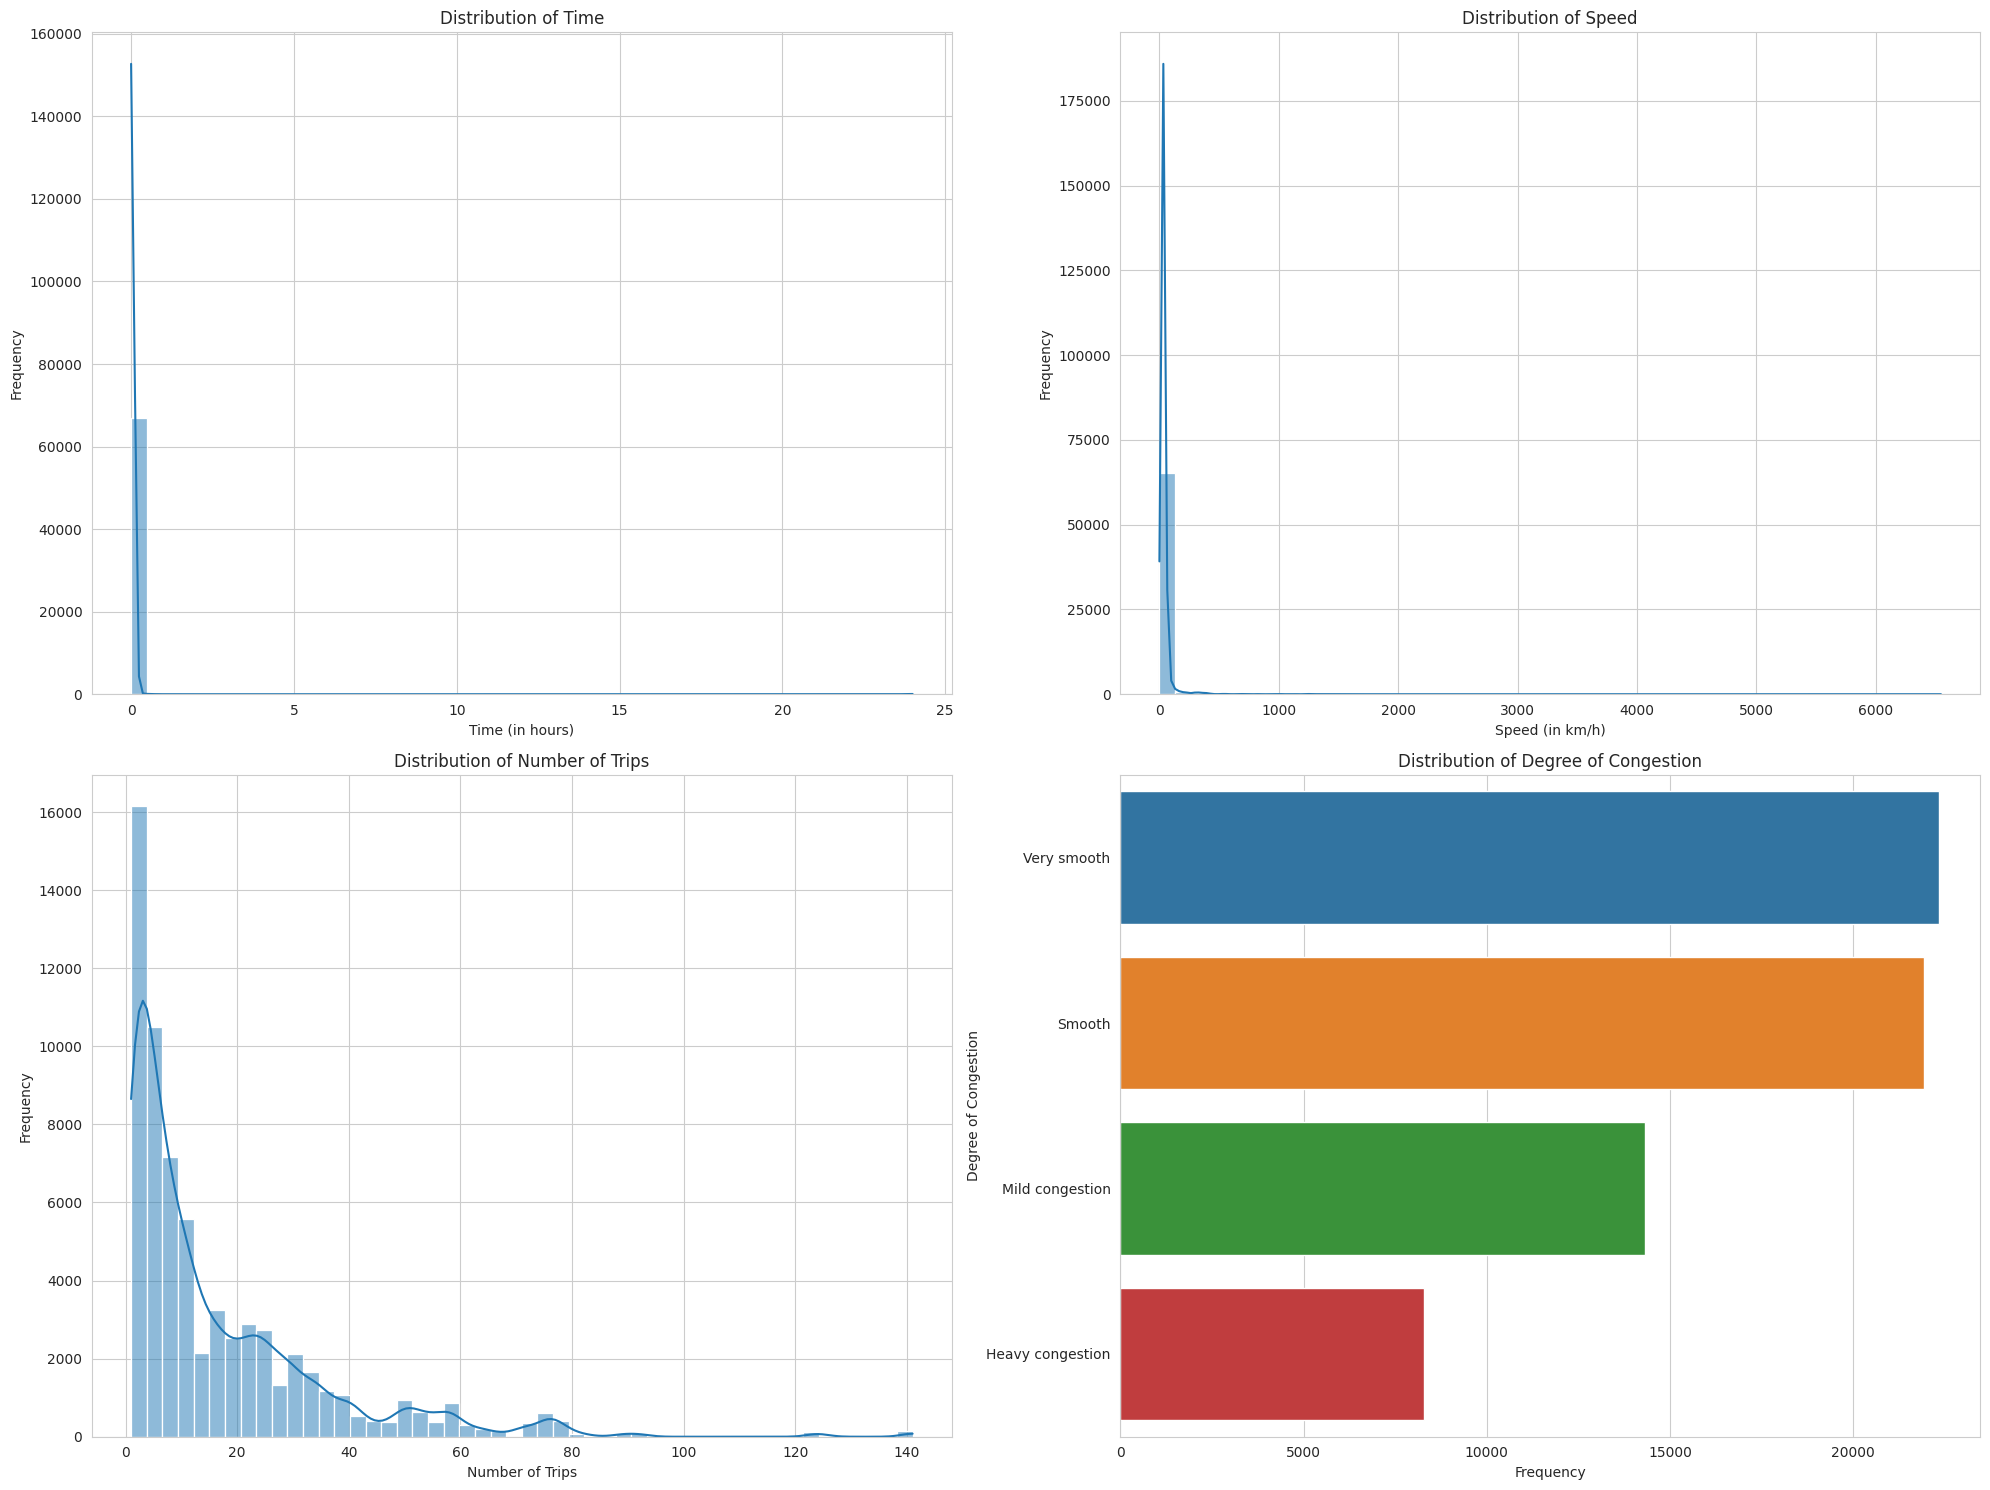

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Initialize the figure
plt.figure(figsize=(20, 15))

# Histogram for the 'time' column
plt.subplot(2, 2, 1)
sns.histplot(data['time'], bins=50, kde=True)
plt.title('Distribution of Time')
plt.xlabel('Time (in hours)')
plt.ylabel('Frequency')

# Histogram for the 'speed' column
plt.subplot(2, 2, 2)
sns.histplot(data['speed'], bins=50, kde=True)
plt.title('Distribution of Speed')
plt.xlabel('Speed (in km/h)')
plt.ylabel('Frequency')

# Histogram for the 'Number_of_trips' column
plt.subplot(2, 2, 3)
sns.histplot(data['Number_of_trips'], bins=50, kde=True)
plt.title('Distribution of Number of Trips')
plt.xlabel('Number of Trips')
plt.ylabel('Frequency')

# Bar plot for the 'Degree_of_congestion' column
plt.subplot(2, 2, 4)
sns.countplot(y=data['Degree_of_congestion'], order = data['Degree_of_congestion'].value_counts().index)
plt.title('Distribution of Degree of Congestion')
plt.xlabel('Frequency')
plt.ylabel('Degree of Congestion')

# Adjust layout
plt.tight_layout()
plt.show()


The visualizations provide some interesting insights:

Distribution of Time: Most trips take very little time, with a peak around 0.01-0.02 hours (i.e., less than a minute). However, there are some trips that take almost 24 hours, which might be outliers or data errors.

Distribution of Speed: The speed of most trips is around 30 km/h, but there's a wide distribution, suggesting varied traffic conditions.

Distribution of Number of Trips: Most of the routes have fewer than 25 trips, with a few routes having over 100 trips.

Distribution of Degree of Congestion: The most common congestion level is "Smooth", followed by "Very smooth". The least common is "Heavy congestion".

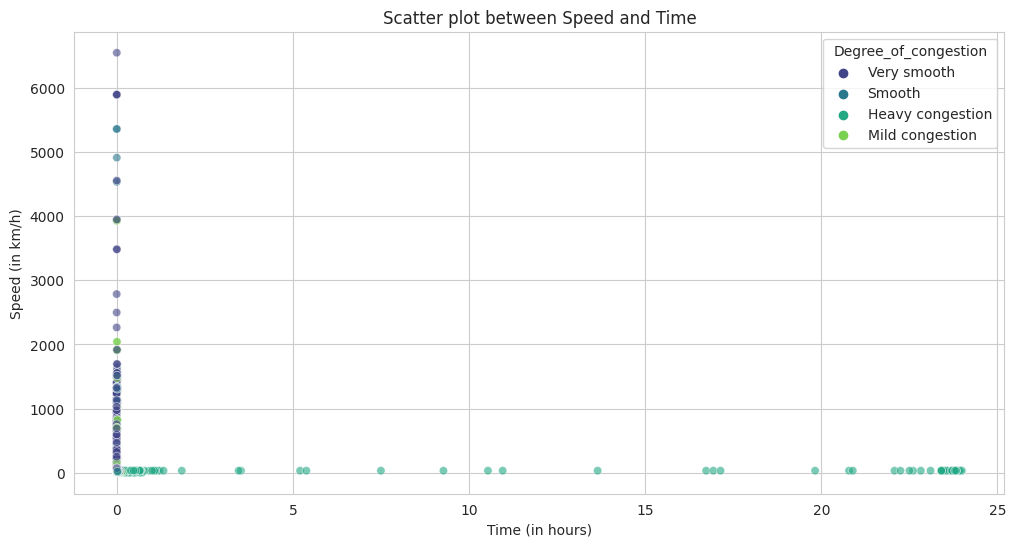

In [9]:
# Scatter plot between 'speed' and 'time'
plt.figure(figsize=(12, 6))
sns.scatterplot(x=data['time'], y=data['speed'], hue=data['Degree_of_congestion'], palette='viridis', alpha=0.6)
plt.title('Scatter plot between Speed and Time')
plt.xlabel('Time (in hours)')
plt.ylabel('Speed (in km/h)')
plt.show()


The scatter plot between speed and time offers a few observations:

Speed vs. Time: There seems to be a concentration of data points around lower times, suggesting that most trips are short in duration. However, as the duration increases, the speed decreases, which might be due to longer trips facing more traffic congestion.

Degree of Congestion: The color hue indicates the degree of congestion. We can observe that for shorter trips with higher speeds, the congestion is generally "Smooth" or "Very smooth". In contrast, longer trips with lower speeds often face "Moderate" to "Heavy congestion".

  # Step 2: Data Preparation
2.1. Feature Processing
Given our current dataset, we need to decide how to handle each feature:

stop_id_from & stop_id_to: These are categorical variables representing the starting and ending stops. We can encode them using one-hot encoding.

trip_id: This seems to be an identifier for the trip. For modeling purposes, we might not need this, but we'll keep it for now and decide later.

arrival_time: This represents the time of arrival and can be transformed into hours and minutes as separate features.

time, speed, and Number_of_trips: These are numerical features and can be used directly.

SRI: This has been processed and can be used directly.

Degree_of_congestion: This is a categorical variable that can be one-hot encoded.

In [10]:
# Convert 'arrival_time' to datetime format and extract hours and minutes as separate columns
data['arrival_hour'] = pd.to_datetime(data['arrival_time']).dt.hour
data['arrival_minute'] = pd.to_datetime(data['arrival_time']).dt.minute

# One-hot encode 'stop_id_from', 'stop_id_to', and 'Degree_of_congestion'
data_encoded = pd.get_dummies(data, columns=['stop_id_from', 'stop_id_to', 'Degree_of_congestion'], drop_first=True)

# Drop the original 'arrival_time' and 'trip_id' columns
data_encoded = data_encoded.drop(columns=['arrival_time', 'trip_id'])

# Display the first few rows of the processed data
data_encoded.head()


,time,speed,Number_of_trips,SRI,arrival_hour,arrival_minute,stop_id_from_437,stop_id_from_440,stop_id_from_441,stop_id_from_442,...,stop_id_to_40475,stop_id_to_40476,stop_id_to_40492,stop_id_to_40509,stop_id_to_40510,stop_id_to_40515,stop_id_to_40516,Degree_of_congestion_Mild congestion,Degree_of_congestion_Smooth,Degree_of_congestion_Very smooth
0,0.027222,14.479565,9.0,-0.40816322,9,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.032222,12.232736,9.0,1.2068965,9,3,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.058333,6.757130,9.0,5.142857,9,15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.033611,11.727251,9.0,1.570248,9,5,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.058333,6.757130,9.0,5.142857,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


To address this, we can consider a few alternatives:

Label Encoding: Instead of one-hot encoding, we can use label encoding for stop_id_from and stop_id_to. This approach will convert each unique category to a unique integer. However, it might introduce ordinal relationships that the model could misinterpret.

Reduce Categories: For columns like stop_id_from and stop_id_to, we can group the less frequent categories into an 'other' category, reducing the number of unique categories. Then we can proceed with one-hot encoding.

Dimensionality Reduction: After encoding, we can use techniques like Principal Component Analysis (PCA) to reduce the number of features.


let's proceed with label encoding for the stop_id_from and stop_id_to columns. We'll still use one-hot encoding for the Degree_of_congestion column since it has fewer unique values.

In [11]:
from sklearn.preprocessing import LabelEncoder

# Label encoding for 'stop_id_from' and 'stop_id_to'
label_encoders = {}
for col in ['stop_id_from', 'stop_id_to']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# One-hot encode 'Degree_of_congestion'
data_encoded = pd.get_dummies(data, columns=['Degree_of_congestion'], drop_first=True)

# Display the first few rows of the processed data
data_encoded.head()


,stop_id_from,stop_id_to,trip_id,arrival_time,time,speed,Number_of_trips,SRI,arrival_hour,arrival_minute,Degree_of_congestion_Mild congestion,Degree_of_congestion_Smooth,Degree_of_congestion_Very smooth
0,2888,3089,NORMAL_333_Pune Station To Hinjawadi Maan Pha...,09:13:54,0.027222,14.479565,9.0,-0.40816322,9,13,0,0,1
1,2888,3089,NORMAL_115P_Pune Station to Hinjawadi Phase 3_...,09:03:01,0.032222,12.232736,9.0,1.2068965,9,3,0,1,0
2,2888,3089,NORMAL_100_Ma Na Pa to Hinjawadi Maan Phase 3_...,09:15:00,0.058333,6.757130,9.0,5.142857,9,15,0,0,0
3,2888,3089,NORMAL_VJR5_Ma Na Pa To Mukai Chowk_Up-0905_0,09:05:00,0.033611,11.727251,9.0,1.570248,9,5,0,1,0
4,2888,3089,NORMAL_100_Ma Na Pa to Hinjawadi Maan Phase 3_...,09:00:00,0.058333,6.757130,9.0,5.142857,9,0,0,0,0


The data has been successfully processed:

The stop_id_from and stop_id_to columns have been label encoded.
The Degree_of_congestion column has been one-hot encoded, resulting in additional columns for each congestion level (excluding the first level to avoid multicollinearity).


  # 2.2. Feature Selection
For modeling purposes, we might not need all the features.

We've already removed the original arrival_time column since we've extracted the arrival_hour and arrival_minute from it.
We should also drop the trip_id column as it's an identifier and won't be useful for predictive modeling.
Let's proceed by dropping the trip_id column and then move on to clustering and anomaly detection.​

In [12]:
# Drop the 'trip_id' column
data_encoded = data_encoded.drop(columns=['trip_id'])

# Display the first few rows of the dataset after dropping the column
data_encoded.head()


,stop_id_from,stop_id_to,arrival_time,time,speed,Number_of_trips,SRI,arrival_hour,arrival_minute,Degree_of_congestion_Mild congestion,Degree_of_congestion_Smooth,Degree_of_congestion_Very smooth
0,2888,3089,09:13:54,0.027222,14.479565,9.0,-0.40816322,9,13,0,0,1
1,2888,3089,09:03:01,0.032222,12.232736,9.0,1.2068965,9,3,0,1,0
2,2888,3089,09:15:00,0.058333,6.757130,9.0,5.142857,9,15,0,0,0
3,2888,3089,09:05:00,0.033611,11.727251,9.0,1.570248,9,5,0,1,0
4,2888,3089,09:00:00,0.058333,6.757130,9.0,5.142857,9,0,0,0,0


  # Step 3: Model Selection and Training

3.1. Train-Test Split
Before training a model, we'll split our dataset into a training set and a test set. This allows us to evaluate the model's performance on unseen data.

3.2. Model Selection
Given that this is a spatio-temporal traffic prediction problem, the nature of the prediction (regression or classification) depends on the target variable. For this exercise, I'll assume we're predicting speed (a continuous variable), making it a regression problem.

We'll consider the following models for regression:

* Linear Regression: A simple linear model.
* Decision Tree Regressor: A tree-based model.
* Random Forest Regressor: An ensemble of decision trees.
* Gradient Boosting Regressor: Boosting-based ensemble method.

3.3. Model Training
We'll train each of the above models on the training set and validate their performance on the test set using the Mean Absolute Error (MAE) metric.



In [28]:
# Model Training

# Convert valid SRI values to float and compute the median
valid_sri_values = data['SRI'][data['SRI'] != '#NAME?'].astype(float)
sri_median = valid_sri_values.median()

# Replace '#NAME?' with the computed median in the dataset
data['SRI'] = data['SRI'].replace('#NAME?', sri_median).astype(float)

data.fillna(method='ffill', inplace=True)
data['arrival_hour'] = pd.to_datetime(data['arrival_time']).dt.hour
data['arrival_minute'] = pd.to_datetime(data['arrival_time']).dt.minute
data_encoded = pd.get_dummies(data, columns=['Degree_of_congestion'], drop_first=True)

X = data_encoded.drop(columns=['speed','trip_id','arrival_time'])
y = data_encoded['speed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    print(f"{name} - Mean Absolute Error: {mae}")



Linear Regression - Mean Absolute Error: 18.36573210113048
Decision Tree - Mean Absolute Error: 4.2194193424484805
Random Forest - Mean Absolute Error: 4.275481846968528
Gradient Boosting - Mean Absolute Error: 10.773888112096474


  # Step 4 : Compare with AutoML

In [31]:
!pip install pycaret

In [36]:
# Libraries
import pandas as pd
from pycaret.regression import *

# Load the data
data = pd.read_csv('/content/gdrive/MyDrive/DataMining/GTFS_Data.csv')

# Setup PyCaret environment
# The setup() function initializes the environment and performs preprocessing, such as missing value imputation, one-hot encoding, etc.
# Assuming 'speed' is the target variable

data.fillna(method='ffill', inplace=True)
reg1 = setup(data, target='speed', session_id=123,
             ignore_features=['trip_id', 'arrival_time'],
             profile=True)

# Compare models to select the best one
best_model = compare_models()



,Description,Value
0,Session id,123
1,Target,speed
2,Target type,Regression
3,Original data shape,"(66913, 9)"
4,Transformed data shape,"(66913, 10)"
5,Transformed train set shape,"(46839, 10)"
6,Transformed test set shape,"(20074, 10)"
7,Ignore features,2
8,Numeric features,4
9,Categorical features,2


Loading profile... Please Wait!
Profiler Failed. No output to show, continue with modeling.


Processing:   0%|          | 0/81 [00:00<?, ?it/s]